In [10]:
import tensorflow as tf
import os
import pathlib
import time
from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm
import numpy as np

In [11]:
import datetime

In [12]:
from utils import load_data

In [13]:
FOLDER = "new_data"

# The facade training set consist of 400 images
BUFFER_SIZE = 288
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [14]:
train_X,train_Y,test_X,test_Y = load_data(FOLDER,"image","mask","jpg","jpg")

In [15]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [16]:
import cv2

In [17]:
def pre_process(image):
    def gammaCorrection(src, gamma):
        invGamma = 1 / gamma

        table = [((i / 255) ** invGamma) * 255 for i in range(256)]
        table = np.array(table, np.uint8)

        return cv2.LUT(src, table)
    image = image[:,:,1]
    clahe = cv2.createCLAHE(clipLimit =0.2, tileGridSize=(32,32))
    img = clahe.apply(image)
    img = gammaCorrection(img,1.2)
    return img

In [23]:
images = []
masks = []
for idx,(img,mask) in tqdm(enumerate(zip(train_X[46:],train_Y[46:]))):
    x = np.expand_dims(np.array(cv2.resize(pre_process(cv2.imread(img)),(IMG_WIDTH,IMG_HEIGHT)), dtype = np.float32), -1)
    y = np.expand_dims(np.array(cv2.resize(cv2.imread(mask, cv2.IMREAD_GRAYSCALE), (IMG_WIDTH,IMG_HEIGHT)), dtype = np.float32),-1)
    cv2.imwrite("pre.png",x)
    
    x,y = normalize(x,y)
    images.append(x)
    cv2.imwrite("img.png",cv2.resize(cv2.imread(img),(256,256)))
    masks.append(y)
    break


0it [00:00, ?it/s]


In [9]:
train_ds = create_dataset(train_X,train_Y)

167it [00:01, 89.44it/s] 


In [ ]:

images = []
masks = []
for idx,(img,mask) in tqdm(enumerate(zip(train_X,train_Y))):
    x = np.array(cv2.resize(cv2.imread(img),(256,256)), dtype = np.float32)
    y = np.array(cv2.resize(cv2.imread(mask), (256,256)), dtype = np.float32)
    x,y = normalize(x,y)
    images.append(x)
    masks.append(y)
return (np.array(images),np.array(masks))

In [10]:
train_ds[0].shape

(288, 256, 256, 3)

In [11]:
test_ds = create_dataset(test_X, test_Y)

40it [00:00, 182.58it/s]


In [12]:
test_ds[0].shape

(40, 256, 256, 3)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_ds)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_ds)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [17]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [18]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [19]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [20]:
generator = Generator()


In [21]:
discriminator = Discriminator()


In [22]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [24]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [25]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
#     print(test_input[0])
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [26]:
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)




In [27]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        step = int(step)
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


(1, 256, 256, 3)


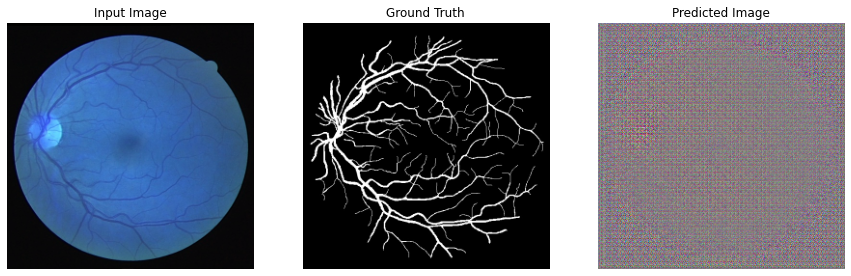

In [28]:
for example_input, example_target in test_dataset.take(1):
    print(example_input.shape)
    generate_images(generator, example_input, example_target)

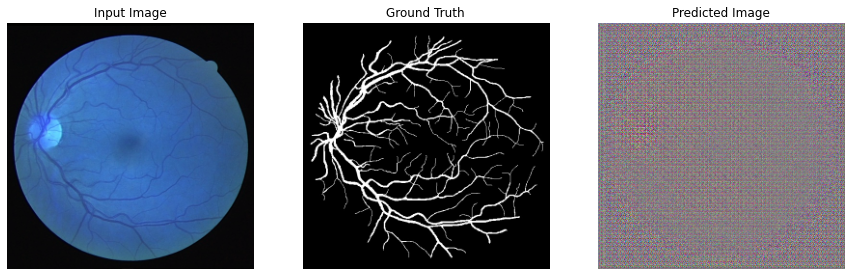

Step: 0k


ResourceExhaustedError: {{function_node __wrapped__Conv2DBackpropFilter_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1024,512,4,4] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropFilter]

In [29]:
fit(train_dataset, test_dataset, steps=40000)